<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Boroujerdi/Boroujerdi_L-2-2_H-128_Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Sat Jul 18 12:25:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!git clone https://github.com/mmsamiei/transformers-zirab
%cd transformers-zirab/
%pip install .

fatal: destination path 'transformers-zirab' already exists and is not an empty directory.
/content/transformers-zirab
Processing /content/transformers-zirab
  Created wheel for transformers: filename=transformers-3.0.2-cp36-none-any.whl size=789366 sha256=c25bad296e4d0ef5c3922fd80718569d5dd07965b0aacd742354ec32d6834f3c
  Stored in directory: /root/.cache/pip/wheels/df/8c/41/d59504f36bccc68fab7ab4a6ba91e9810d1ae946282e7d0c7e
Successfully built transformers
  Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2


In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

In [8]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        #self.dialogues = self.dialogues.sample(frac=frac)
        
        if bound:
          len_prt = int(len(self.dialogues) / 5)
          self.dialogues = self.dialogues[ : len_prt]

        # s = self.dialogues['response'].apply(dec_tokenizer.encode).apply(len).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)

        

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        if knowledge == "":
          knowledge_tensor = response_tensor
        else:
          knowledge_tensor = torch.LongTensor(dec_tokenizer.encode(knowledge, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor,
                  'knowledge': knowledge_tensor}

        return sample

In [9]:
train_dataset = MyDataset(train_file, max_len=128, bound=False)
valid_dataset = MyDataset(valid_file, max_len=128)
test_seen_dataset = MyDataset(test_seen_file, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=128)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_seen_dataset))
print(len(test_unseen_dataset))

41489
4458
2224
2075


In [10]:
print(enc_tokenizer.decode(train_dataset[100]['input_pair']))
print(dec_tokenizer.decode(train_dataset[100]['response']))

[CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
[CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]


In [11]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])

  max_len_knowledge = max([len(data['knowledge']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)
  result_knowledge = torch.zeros(len_batch, max_len_knowledge)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

    p5 = len(data['knowledge'])
    result_knowledge[i, :p5] = data['knowledge']

  return result_input_pair.long(), result_input_pair_segments.long()\
  ,result_response.long(), result_knowledge.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch, knowledge_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print(knowledge_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 67])
torch.Size([64, 64])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 56])
torch.Size([64, 78])
****
649
70


# Model

In [12]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-2_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input, **kwargs):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs['token_type_ids'] = segments_tensors
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    kwargs ['token_type_ids'] = segments_tensors
    generated = model.seq2seq.generate(input_ids=encoder_input,
        decoder_start_token_id=101,bos_token_id=101,
        eos_token_id=102, **kwargs)

    #### generated = [1, len]
    return generated

    

In [13]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f1669604cf8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.sel

8951738


#Optimizer



In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
decoder_optimizer = torch.optim.Adam(model.seq2seq.decoder.parameters(), lr=3e-4)

In [15]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)
decoder_scheduler = get_constant_schedule(decoder_optimizer)

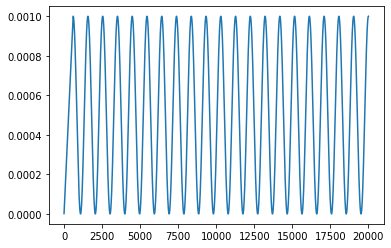

In [ ]:
lrs = []
for i in tqdm(range(20000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [16]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

In [17]:
def get_weights(_lambda = 0):
  weights = torch.ones(dec_tokenizer.vocab_size)
  # for idx, freq in enumerate(freqs):
  #   weight = 1 / (freq**_lambda)
  #   weights[idx] = weight
  return weights

In [18]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    print("Easy training")
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [19]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch, knowledge_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  del knowledge_batch
  return loss.item()

def train_decoder_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch, knowledge_batch = batch
  batch_size = knowledge_batch.shape[0]
  knowledge_batch = knowledge_batch.to(dev)
  encoder_outputs = torch.Tensor(batch_size,100,128).fill_(0).to(dev)
  kwargs = {'encoder_outputs' : (encoder_outputs, None, None)}
  model_output = model(None, None, knowledge_batch, **kwargs)
  loss = mahdi_loss(model_output, knowledge_batch)
  decoder_optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.seq2seq.decoder.parameters(), 2)
  decoder_optimizer.step()
  decoder_scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  del knowledge_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch, knowledge_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    del knowledge_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader), leave=False):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':8,'num_return_sequences':8,'temperature':1,
            'no_repeat_ngram_size':3}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3
          }
  valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=100, **kwargs):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [20]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi/L-2-2_H-128_Plus/"
  step = 0
  log_list = []

In [ ]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-6-6_H-128_Plus/"
checkpoint = torch.load(model_dir+'/montazeri_20000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

In [21]:
from tqdm.auto import tqdm

MAX_STEP = 50000
STEP_SAVE = 1000
STEP_CHECK = 1000
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader), leave=False):
    step_loss = train_step(batch_idx, batch)
    decoder_step_loss = train_decoder_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss, 'decoder_loss':decoder_step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      decoder_train_losses = [step['decoder_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      avg_decoder_train_loss = sum(decoder_train_losses) / len(decoder_train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))
      print("decoder train Loss rate: {} at step {}".format(avg_decoder_train_loss, step_num))
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict()
            }, model_dir+'boroujerdi_{}steps.model'.format(step_num))
    step_num += 1

1


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is hiking in the united states, hiking is usually in the countryside. [SEP] [SEP] [SEP]
model says:  [CLS] hiking is hiking in the united states. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is hiking in the united states in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is hiking in the united states, hiking, hiking is usually in the countryside. [SEP]
model says:  [CLS] hiking is a broad vigorous walk in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is hiking in the united states, hiking 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually in the countryside. [SEP] [SEP] [SEP]
model says:  [CLS] hiking is also used for shorter, vigorous walk, usually in the countryside. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is a long, vigorous walk, usually in the countryside. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually in the countryside, in canada,
model says:  [CLS] hiking is the preferred term for shorter, vigorous walk, usually in the countryside, while in the
model says:  [CLS] hiking is the preferred term for shor

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually in the countryside, while in
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually in the countryside, usually for
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually for shorter, particularly in the
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually for shorter, particularly in canada
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usu

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ) in the countryside
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ), in the
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term, in canada and the united states, in the countryside, while in
model says:  [CLS] hiking is the preferred term, in canada and the united states, for shorter, particularly in canada
model says:  [CLS] hiking is the preferred term for shorter, in canada and the united states, in the countryside,

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is a vigorous walk on trails in the countryside, vigorous walk, usually on trails ( foot
model says:  [CLS] hiking is the preferred term, in canada and the countryside is a vigorous walk in the countryside.
model says:  [CLS] hiking is the preferred term, in canada and the countryside is used for shorter, particularly urban walks
model says:  [CLS] hiking is the preferred term, in canada and the countryside is a vigorous walk in the countryside,
model says:  [CLS] hiking is the preferred term, in canada and the united states is used for shorter, particularly urban
model says:  [CLS] hiking is a vigorous walk on 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term for shorter, in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for shorter, in canada and the united states. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for shorter, particularly in canada
model says:  [CLS] hiking is the preferred term, in can

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ), in the
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ) in the countryside
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ), in canada
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpath, in the countryside,
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths in the countryside,
model says:  [CLS] hiking is a long, vigorous walk, generally on trails ( footpaths ), in the
model says:  [CLS] hiking is the preferred term, in canad

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ), in the
model says:  [CLS] hiking is the preferred term, in canada and the united states, for long, vigorous walk,
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths in the countryside,
model says:  [CLS] hiking is a long, vigorous walk, usually on trails, footpaths, in the countryside
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ) in the countryside
model says:  [CLS] hiking is the

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is used for a long, vigorous walk, usually on trails, footpaths, in
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails in the countryside,
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails, footpaths
model says:  [CLS] hiking is used for a long, vigorous walk, usually on trails ( footpaths ),
model says:  [CLS] hiking i

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is also used for a long, vigorous walk, usually on trails, footpaths,
model says:  [CLS] the word hiking is used for a long, vigorous walk, usually on trails, footpaths
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails, footpaths
model says:  [CLS] the word hiking is used for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] the word hiking is used for a long, vigorous walk, usually on trails [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is a preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term, in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails in the countryside,
model says:  [CLS] hiking is the word walking is used for shorter, particularly urban walk

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] hiking is the preferred term in canada and the united states, for a long, vigorous walk,
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ), in the
model says:  [CLS] hiking is a long, vigorous walk, usually on trails ( footpaths ), in canada
model says:  [CLS] hiking is the preferred term, in canada and the united states, for shorter, particularly urban walks
model says:  [CLS

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term, in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for shorter, particularly urban walks
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails, footpaths
model says:  [CLS] the word walking is used for shorter, particularly urban walks [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term, in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term in canada and the united states, for a long, vigorous walk,
model says:  [CLS] hiking is also used for a long, vigorous walk, usually on trails, footpaths,
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails, footpaths
model says:  [CLS] the word walking is used for a long, vigorous walk, usually on trails ( footpaths
model

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] the word walking is used for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is a long, vigorous walk, usually on trails, footpaths, in the countryside
model says:  [CLS] the word walking is used for a long, vigorous walk, usually on trails, footpaths
model says:  [CLS] the word walking is used for shorter, particularly urban walks [SEP] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] hiking is the preferred term, in canada and the united states, for a long, vigorous walk
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails, in the countryside
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, in the countryside, while the word
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually on trails ( footpaths
model says:  [CLS] the word walking is used for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking is the preferred term for a long, vigorous walk, usually o

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] hiking [SEP] hiking is the preferred term, in canada and the united states, for a long, vigorous walk, usually on trails ( footpaths ), in the countryside, while the word walking is used for shorter, particularly urban walks. [SEP]
response is:  [CLS] i love going hiking! it's so nice to hike through the countryside and on trails. [SEP]
model says:  [CLS] the word walking is used for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] the word walking is also used for shorter, particularly urban walks [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] the word walking is used for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] the word walking is also used for shorter, particularly urban walks. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] hiking in canada and the united states, in the countryside, while the word walking is used for
model says:  [CLS] hiki

KeyboardInterrupt: ignored

In [24]:
kwargs = {'num_beams':2,
          'num_return_sequences':2,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          #'top-k':5,
          #'top_p':0.97,
          #'do_sample':True
          }
#kwargs = {}
valid_inference(idx=2, **kwargs)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] re all such interesting concepts. [SEP] i'm a huge fan of science fiction myself! [SEP] awesome! i really love how sci - fi storytellers focus on political / social / philosophical issues that would still be around even in the future. makes them relatable. [SEP] i agree. one of my favorite forms of science fiction is anything related to time travel! i find it fascinating. [SEP] the central premise for these stories oftentimes involves changing history, either intentionally or by accident, and the ways by which altering the past changes the future and creates an altered present or future for the time traveler when they return home. [SEP]
response is:  [CLS] it's not quite sci - fi, but my favorite version of time travel is in harry potter and the prisoner of azkaban. breaks zero logical rules. [SEP]
model says:  [CLS] i think it's not too, but not really, but the game is the game of the same rules.
model says:  [CLS] i think it's not too, but not really, but the game is 

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()

f_scores = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {#'num_beams':1,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':2,
            'do_sample':True
            #'top-k':1
            }
  #kwargs = {}
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  if i % 100 == 0 :
    print( sum(f_scores) / len(f_scores))
print( sum(f_scores) / len(f_scores))

0.23728813559322032
0.24728154864316473


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()

f_scores = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {#'num_beams':1,
            'num_return_sequences':100,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':3,
            'do_sample':True
            #'top-k':1
            }
  #kwargs = {}
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  case_f_scores = []
  for generated in generateds:
    generated = generated.cpu().numpy()
    responsed = response.squeeze(0).cpu().numpy()
    intersections = np.intersect1d(generated, responsed)
    recall = len(intersections) / len(responsed)
    precision = len(intersections) / len(generated)
    f1_score = 2 * (precision * recall) / (precision + recall)
    case_f_scores.append(f1_score)
  f_scores.append(max(case_f_scores))
  if i % 20 == 0 :
    print( sum(f_scores) / len(f_scores))
print( sum(f_scores) / len(f_scores))

0.16666666666666666
0.1189438997564654


KeyboardInterrupt: ignored